In [1]:
import pandas as pd
import numpy as np
import os, os.path

In [2]:
features = ["Tm", "Rec_ID", "AvgTamb", "AvgHamb", "AvgGSi00", "AvgTSi00", 
            "AvgSPN1_G", "AvgSPN1_D", "AvgWind_S", "AvgWind_D", "AvgAir_P"]
dataf = pd.DataFrame([], columns = features)

In [3]:
def is_non_zero_file(fpath):  
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

In [4]:
# get all txt files from the directory init_dir and all sub-directories
init_dir = "401"
flist  = []
 
for root, dirs, files in os.walk(init_dir):
    try:
        for f in files:
            fullpath = os.path.join(root, f)
            if (is_non_zero_file(fullpath)) & (os.path.splitext(fullpath)[1] == '.txt'):
                flist.append(fullpath)
    except Exception as e:
        raise e
        print( "No files found here!")
# print(flist[1])
print(len(flist))



1122


In [5]:
# generate all the 15-min averages for all the files 
features_to_analyze = ["AvgTSi00", "AvgSPN1_D"]

dataAvg = []

avg_len = 15 # average for every 15 minutes
seq_len = 72 # 72 = 18 hours * 4 (four is the number of 15 min intervals in 1 hour) 

for fullpath in flist:
    # arrays for the 15 min means
    data = pd.read_csv(fullpath,delimiter="\t")        
    pd_len = data.shape[0]  # all length of the sequence
    #     print(fullpath)
    # and then average everything using 15 min reading
    for i in range(0,pd_len-avg_len,avg_len):
        seq_in = data.iloc[i:i + avg_len][features_to_analyze].mean()  # not inclusive the higher limit
        seq_in = np.array(seq_in).reshape(2)
        dataAvg.append(seq_in)
    # and now for list of avg values make a test data    
print("Total sequences: {}".format(len(dataAvg)))

Total sequences: 106572


In [6]:
features_to_analyze = ["AvgTSi00", "AvgSPN1_D"]
featurs_len = len(features_to_analyze)
# print(dataAvg[1][1])

In [7]:
dataX = []
dataY = []

for element in range(0, len(dataAvg)-seq_len-1, 1):
    # and now make a list of test data from avg values
    Z = np.array(dataAvg[element:element+seq_len]).reshape(seq_len,featurs_len)
    dataX.append(Z)
    dataY.append(dataAvg[element+seq_len+1][1])
    
print("Total sequences: {}".format(len(dataX)))

Total sequences: 106499


In [8]:
n_patterns = len(dataX)
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)

(106499, 72, 2)


In [9]:
Mx = X.max(axis=1).max(axis=0)
Mn = X.min(axis=1).min(axis=0)
M = X.mean(axis=1).mean(axis=0)
MM = Mx-Mn

In [10]:
for i in (range(X.shape[0])):
    for j in (range(X.shape[1])):
        X[i][j] -= M
        X[i][j] /= MM

In [11]:
# reshape X to be [samples, time steps, features]
Y = np.reshape(dataY, (n_patterns, 1))
print(Y.shape)


(106499, 1)


In [12]:
Y -= M[1]         
Y /= MM[1]    

In [13]:
np.savez_compressed('data', dataX=dataX, dataY=dataY, X=X, Y=Y)


In [14]:
DataSet = np.load('data.npz')

In [15]:
dataX = DataSet['dataX']
dataY = DataSet['dataY']
n_patterns = len(dataX)

In [16]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)       


(106499, 72, 2)


In [17]:
Mx = X.max(axis=1).max(axis=0)
Mn = X.min(axis=1).min(axis=0)
# print(Z)
# print(len(Z))
# print(Z.shape)

M = X.mean(axis=1).mean(axis=0)
print(M)
MM = Mx-Mn

W = X[3][4]
print(W,"\n",M,"\n",W-M,"\n",MM,"\n",(W-M)/MM)
print((W[1]-M[1])/MM[1])

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_len, featurs_len))
print(X.shape)

[  31.89318985  108.12619017]
[ 26.7588       3.08073333] 
 [  31.89318985  108.12619017] 
 [  -5.13438985 -105.04545684] 
 [  50.41953333  664.57513333] 
 [-0.10183335 -0.15806408]
-0.158064079691
(106499, 72, 2)


In [18]:
# reshape X to be [samples, time steps, features]
Y = np.reshape(dataY, (n_patterns, 1))
print(Y.shape)


(106499, 1)


In [19]:
for i in (range(X.shape[0])):
    for j in (range(X.shape[1])):
        X[i][j] -= M 
        X[i][j] /= MM
        
Y -= M[1]         
Y /= MM[1]         

In [20]:
import numpy as np
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf

Using TensorFlow backend.


In [21]:
# define the input shape
print(X.shape)
inp = Input(shape=(X.shape[1], X.shape[2]))
print('our input shape is ',(X.shape[1], X.shape[2]) )

(106499, 72, 2)
our input shape is  (72, 2)


In [22]:
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [24]:
x = LSTM(256, return_sequences = True)(inp) 
x = Dropout(0.2)(x)
x = LSTM(256)(x)
x = Dropout(0.2)(x)
# output = Dense(Y.shape[1])(x)
# model.add(Activation('relu')) #'linear'
output = Dense(Y.shape[1], activation='relu')(x)

In [25]:
generative_model = Model(inputs = inp, outputs=output)
optimizer = RMSprop(lr=0.01)
generative_model.compile(loss='mean_squared_error', optimizer='RMSprop')


In [27]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gentext-Telemetry.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [28]:
history = generative_model.fit(X, Y, epochs=15, batch_size=256, callbacks=callbacks_list, validation_split=0.2)


Train on 85199 samples, validate on 21300 samples
Epoch 1/15
85199/85199 [==============================] - 1180s - loss: 0.0197 - val_loss: 0.0196
Epoch 2/15
85199/85199 [==============================] - 979s - loss: 0.0182 - val_loss: 0.0194
Epoch 3/15
85199/85199 [==============================] - 975s - loss: 0.0180 - val_loss: 0.0183
Epoch 4/15
85199/85199 [==============================] - 984s - loss: 0.0179 - val_loss: 0.0182
Epoch 5/15
85199/85199 [==============================] - 992s - loss: 0.0179 - val_loss: 0.0181
Epoch 6/15
85199/85199 [==============================] - 982s - loss: 0.0183 - val_loss: 0.0185
Epoch 7/15
85199/85199 [==============================] - 976s - loss: 0.0179 - val_loss: 0.0184
Epoch 8/15
85199/85199 [==============================] - 976s - loss: 0.0178 - val_loss: 0.0181
Epoch 9/15
85199/85199 [==============================] - 980s - loss: 0.0180 - val_loss: 0.0192
Epoch 10/15
85199/85199 [==============================] - 976s - loss: 0.01

In [29]:
i=1
x = np.reshape(X[i], (1, X.shape[1], X.shape[2]))
prediction = generative_model.predict(x, verbose=0)

In [30]:
print(prediction)
print(Y[1])
print(abs(Y[1]-prediction)*MM[1])

[[ 0.]]
[-0.13861235]
[[ 92.1183235]]


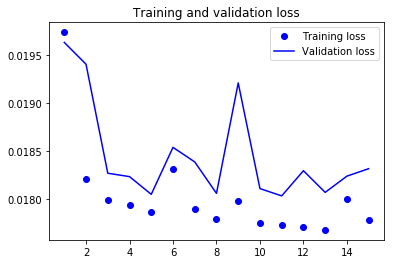

In [31]:
import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
# Evaluate model with test data set and share sample prediction results
x_test, y_test = X,Y
batch_size = 128
evaluation = generative_model.evaluate(x_test, y_test,
          batch_size=batch_size)


106496/106499 [============================>.] - ETA: 0s

IndexError: invalid index to scalar variable.

In [41]:
print('Model Loss = %.2f' % (evaluation))
generative_model.save('Tele1_model')

Model Loss = 0.02


In [43]:
preds = generative_model.predict(x_test)

In [45]:
print(type(preds))
len(preds)

<class 'numpy.ndarray'>


106499

In [48]:

Diff = (preds-Y)
type(Diff)
print(Diff[1])
print(np.mean(Diff), np.max(Diff),np.std(Diff))

[ 0.13861235]
0.0817687411986 0.549706925178 0.105817502804


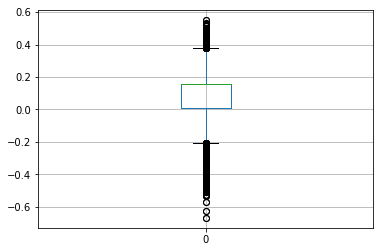

In [53]:
from pandas import DataFrame
results = DataFrame(Diff)
results.boxplot()
plt.show()
